# Real-world data tutorial

This is example of our project application. 
We use published Kaggle cardiac MRI images dataset htttps://www.kaggle.com/c/second-annual-data-science-bowl. 
And we use ukbb_cardiac network https://github.com/baiwenjia/ukbb_cardiac [1]. It was trained on UK Biobank cardiac dataset.
We want to know how good it works on Kaggle dataset.

We use fasta.vision library to perform image transformations like rotation, changing brightness and others.

In [ ]:
from fastai.vision import *
import tensorflow.compat.v1 as tf
import altair as alt

In [ ]:
from misas.core import *

We use kaggle dataset containing CMR images and masks.

In [ ]:
img = lambda: open_image("example/kaggle/images/1-frame014-slice006.png")
trueMask = lambda: open_mask("example/kaggle/masks_full/1-frame014-slice006.png")

In [ ]:
class ukbb_model:
    def __init__(self, model_path):
        tf.disable_eager_execution()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(f'{model_path}.meta')
        saver.restore(self.sess, model_path)
        
    def prepareSize(self, image):
        _, X, Y = image.shape
        image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
        return image
    
    def image_to_input(self, image):
        img = image.clone()
        self.prepareSize(img)
        img_data = img.data[0]#.transpose(1,0).flip(dims=(1,))
        #img_data = rescale_intensity(img_data.numpy(), (1,99))
        img_data = np.expand_dims(img_data, 0)
        img_data = np.expand_dims(img_data, -1)
        return img_data
    
    def predict(self, image):
        image_data = self.image_to_input(image)
        preds, classes = self.sess.run(['prob:0', 'pred:0'],
                   feed_dict={'image:0': image_data, 'training:0': False})
        preds = np.squeeze(preds, 0)
        classes = ImageSegment(ByteTensor(classes))
        return classes, preds
        

We use UK Biobank cardiac neural network downloaded from UK Biobank website https://www.ukbiobank.ac.uk

In [ ]:
model = ukbb_model('example/kaggle/FCN_sa')

INFO:tensorflow:Restoring parameters from example/kaggle/FCN_sa


## Analysis of one image

### Sensitivity to dihedral transformation

Example of applying dihedral transformation function

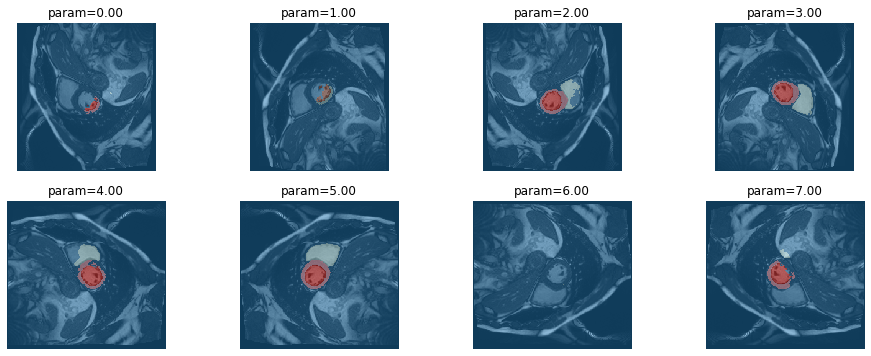

In [ ]:
plot_series(get_dihedral_series(img(),model), nrow=2)

Without flipping and rotating network doesn't recognize heart (image "param = 0.00"). Dihedral transformation was applied. It helps transpond the image to the same coordinate axes as those of the images on which the neural network was trained. The best prediction was obtained after one image transposition and one flip (image "param = 5.00")

In [ ]:
results = eval_dihedral_series(img(),trueMask(),model,components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['k'],value_vars=['LV','MY','RV']))
 .mark_circle(size=60)
 .encode(
     x="k",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
def prep_with_dihedral(image):
    image = image.clone()
    _, X, Y = image.shape
    image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
    return image.dihedral(5)

In [ ]:
model.prepareSize = prep_with_dihedral

### Sensitivity to resize

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


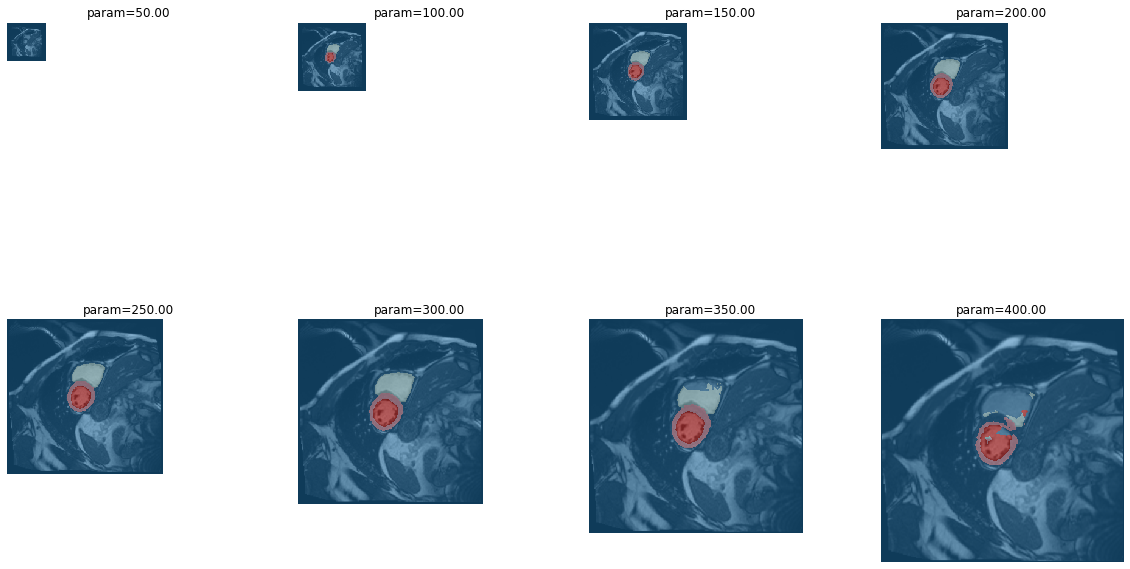

In [ ]:
plot_series(get_resize_series(img(),model, start=50, end=401,step=50), sharex=True, sharey=True, figsize=(20,10), nrow=2)

In [ ]:
results = eval_resize_series(img(),trueMask(),model,end=600,step=30, components=["bg","LV","MY","RV"])

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
(alt
 .Chart(results.melt(id_vars=['px'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="px",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
imgs = get_resize_series(img(),model, start=50, end=401,step=50)

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
imgs

[[50, Image (3, 64, 64), ImageSegment (1, 64, 64), None],
 [100, Image (3, 112, 112), ImageSegment (1, 112, 112), None],
 [150, Image (3, 160, 160), ImageSegment (1, 160, 160), None],
 [200, Image (3, 208, 208), ImageSegment (1, 208, 208), None],
 [250, Image (3, 256, 256), ImageSegment (1, 256, 256), None],
 [300, Image (3, 304, 304), ImageSegment (1, 304, 304), None],
 [350, Image (3, 352, 352), ImageSegment (1, 352, 352), None],
 [400, Image (3, 400, 400), ImageSegment (1, 400, 400), None]]

In [ ]:
padded_imgs = [[x[0], x[1].crop_pad(400, padding_mode="zeros"), x[2].crop_pad(400, padding_mode="zeros")] for x in imgs]

In [ ]:
gif_series(
    padded_imgs,
    "example/kaggle/resize_ukbb.gif",
    param_name="size",
    duration=400
)

![segmentation sensitivity to resizing](example/kaggle/resize_ukbb.gif)

**TODO: add prep_with_dihedral_and_resize**

### Sensitivity to rotation

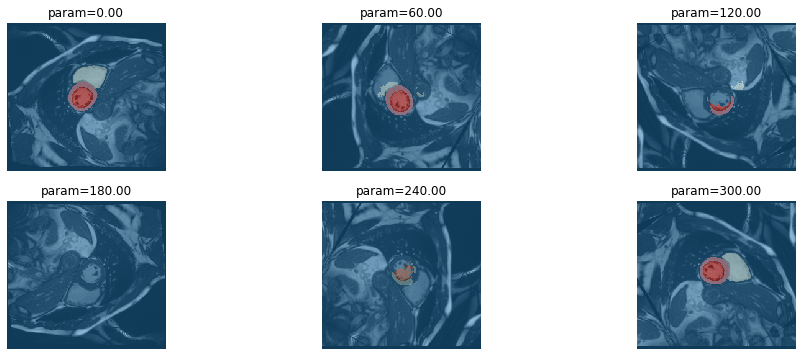

In [ ]:
plot_series(get_rotation_series(img(),model), nrow=2)

In [ ]:
results = eval_rotation_series(img(),trueMask(),model,components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="deg",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to cropping

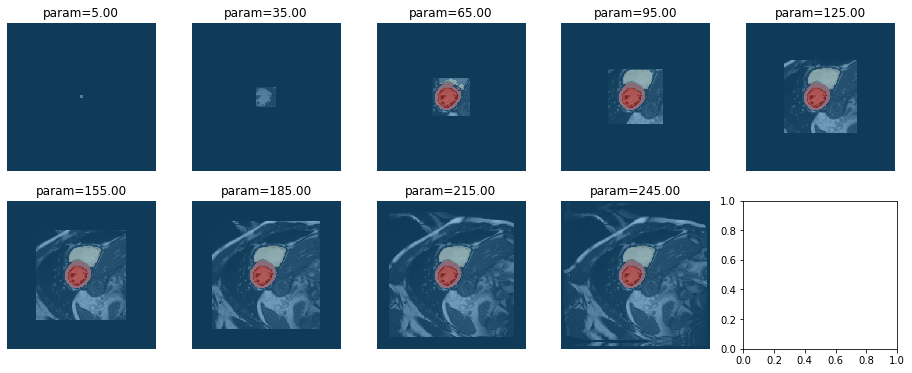

In [ ]:
plot_series(get_crop_series(img(),model, start = 5, step = 30), nrow=2)

In [ ]:
results = eval_crop_series(img(),trueMask(),model,start = 5, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="pixels",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to brightness

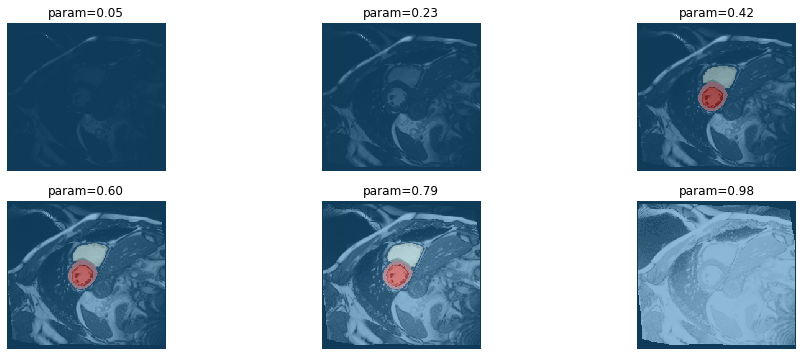

In [ ]:
plot_series(get_brightness_series(img(),model, end = 0.99, step = 0.185), nrow=2)

In [ ]:
results = eval_bright_series(img(),trueMask(),model, end = 0.99, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="brightness",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to contrast

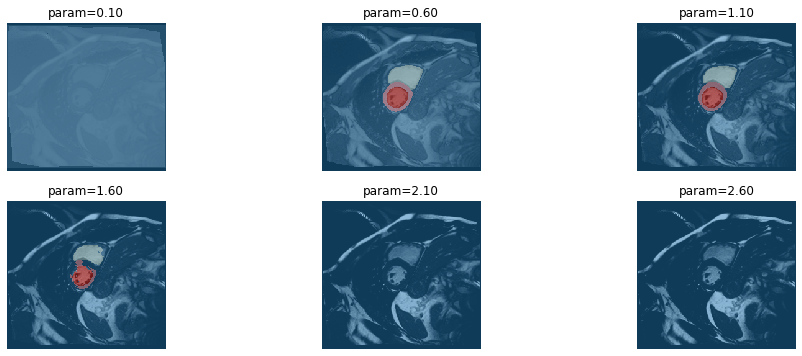

In [ ]:
plot_series(get_contrast_series(img(),model, start=0.1, end=3, step=0.5), nrow = 2)

In [ ]:
results = eval_contrast_series(img(),trueMask(),model, end = 2.5, step = 0.3, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="contrast",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to zoom

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


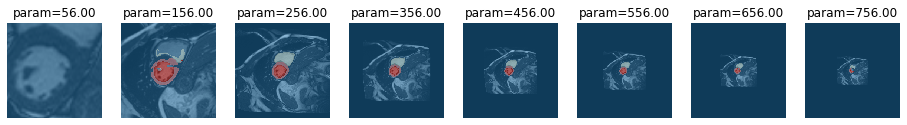

In [ ]:
plot_series(get_zoom_series(img(),model,end=850,step=100))

In [ ]:
results = eval_zoom_series(img(),trueMask(),model,end=1000,step=100,components=["bg","LV","MY","RV"])

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
(alt
 .Chart(results.melt(id_vars=['scale'],value_vars=['LV','MY','RV']))
 .mark_line()
 .encode(
     x="scale",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

[1] W. Bai, et al. Automated cardiovascular magnetic resonance image analysis with fully convolutional networks. Journal of Cardiovascular Magnetic Resonance, 20:65, 2018.